In [128]:
import torch
import time
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split,Dataset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

## Preparing Data

In [129]:
import torch.nn as nn
import torch.nn.functional as F

In [130]:
transform=transforms.Compose([transforms.ToTensor()])

In [131]:
mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=False)
mnist_test = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

In [132]:
data =mnist_train.data.numpy().astype(np.float32)/255.0
labels=mnist_train.targets.numpy()

In [133]:
data=data.reshape(data.shape[0],-1) 

In [134]:
data_train,data_temp,labels_train,labels_temp=train_test_split(data,labels,test_size=0.4,random_state=42,stratify=labels)
data_val,data_test,labels_val,labels_test=train_test_split(data_temp,labels_temp,test_size=0.5,random_state=42,stratify=labels_temp)

In [135]:
print("train:",data_train.shape,labels_train.shape)
print("val:",data_val.shape,labels_val.shape)
print("test:",data_test.shape,labels_test.shape)

train: (36000, 784) (36000,)
val: (12000, 784) (12000,)
test: (12000, 784) (12000,)


In [136]:
data_train_tensor=torch.tensor(data_train)
labels_train_tensor=torch.tensor(labels_train,dtype=torch.long)

data_val_tensor=torch.tensor(data_val)
labels_val_tensor=torch.tensor(labels_val,dtype=torch.long)

data_test_tensor=torch.tensor(data_test)
labels_test_tensor=torch.tensor(labels_test,dtype=torch.long)

In [137]:
trainig_dataset=TensorDataset(data_train_tensor,labels_train_tensor)
validation_dataset=TensorDataset(data_val_tensor,labels_val_tensor)
testing_dataset=TensorDataset(data_test_tensor,labels_test_tensor)  

In [138]:
training_loader=DataLoader(trainig_dataset,batch_size=64,shuffle=True)
validation_loader=DataLoader(validation_dataset,batch_size=64,shuffle=False)
testing_loader=DataLoader(testing_dataset,batch_size=64,shuffle=False)

# A2 . Logistic Regression 

###  Binary Classification Task


In [139]:
zero_one_training=(labels_train_tensor==0)|(labels_train_tensor==1)
zero_one_validation=(labels_val_tensor==0)|(labels_val_tensor==1)


In [140]:
data_trianing_binary=data_train_tensor[zero_one_training]
labels_training_binary=labels_train_tensor[zero_one_training].unsqueeze(1)

In [141]:
data_validation_binary=data_val_tensor[zero_one_validation]
labels_validation_binary=labels_val_tensor[zero_one_validation].unsqueeze(1)

In [142]:
number_of_features=data_trianing_binary.shape[1] #number of input pixels
W=torch.zeros((number_of_features,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)

lr=0.01
num_epochs=1000 #how many times to iterate over the training set

In [143]:
def segmoid(z):
    return 1/(1+torch.exp(-z))

In [144]:
def linear_output(X,W,b):
    return torch.matmul(X,W) +b

In [145]:
training_losses=[]
validation_losses=[]
training_accuracies=[]
validation_accuracies=[]
start = time.time()
for epoch in range(num_epochs):
    #Forward pass
    linear_out=linear_output(data_trianing_binary,W,b)
    labels_predection=segmoid(linear_out)
    
    #Compute loss
    training_loss = -torch.mean(labels_training_binary*torch.log(labels_predection)+(1-labels_training_binary)*torch.log(1-labels_predection)) 
    
    #training accuracy
    labels_training_predection=(labels_predection>=0.5).float()
    training_accuracy=torch.mean((labels_training_predection==labels_training_binary).float())

    # validattion pass
    with torch.no_grad():
        linear_out_val=linear_output(data_validation_binary,W,b)
        labels_predection_val=segmoid(linear_out_val)
        
        #Compute validation loss
        validation_loss = -torch.mean(labels_validation_binary*torch.log(labels_predection_val)+(1-labels_validation_binary)*torch.log(1-labels_predection_val)) 
        
        #validation accuracy
        labels_validation_predection=(labels_predection_val>=0.5).float()
        validation_accuracy=torch.mean((labels_validation_predection==labels_validation_binary).float())
    #Backward pass on training loss
    training_loss.backward()
    #Update weights
    with torch.no_grad():
        W-=lr*W.grad
        b-=lr*b.grad

    # Reset gradients
    W.grad.zero_()
    b.grad.zero_()
    
    # Store losses and accuracies
    training_losses.append(training_loss.item())
    validation_losses.append(validation_loss.item())
    training_accuracies.append(training_accuracy.item())
    validation_accuracies.append(validation_accuracy.item())
    if (epoch+1)%100==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {training_loss.item():.4f}')
end_time = time.time()
logistic_regression_time = end_time-start
print(logistic_regression_time)

Epoch [100/1000], Loss: 0.1201
Epoch [200/1000], Loss: 0.0701
Epoch [300/1000], Loss: 0.0515
Epoch [400/1000], Loss: 0.0416
Epoch [500/1000], Loss: 0.0354
Epoch [600/1000], Loss: 0.0311
Epoch [700/1000], Loss: 0.0280
Epoch [800/1000], Loss: 0.0255
Epoch [900/1000], Loss: 0.0236
Epoch [1000/1000], Loss: 0.0220
3.461029529571533


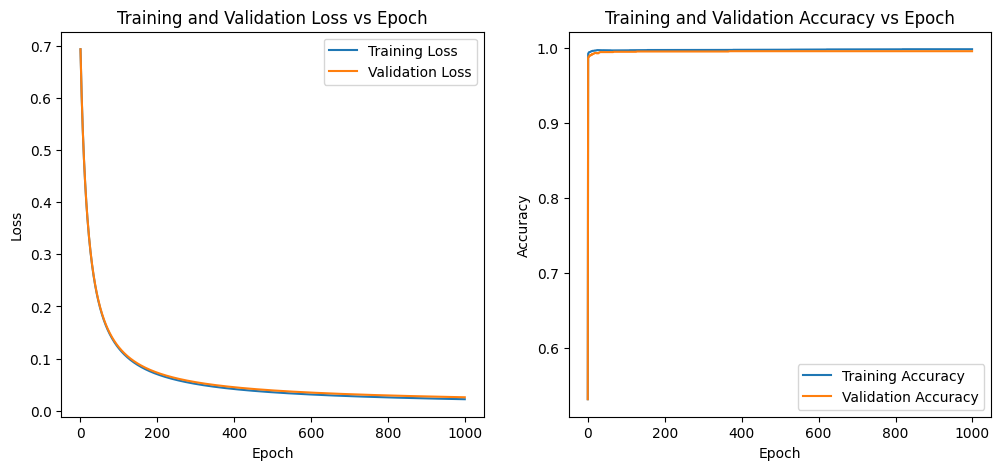

In [146]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(training_losses,label='Training Loss')
plt.plot(validation_losses,label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(training_accuracies,label='Training Accuracy')
plt.plot(validation_accuracies,label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Epoch')
plt.legend()

plt.show()

### Final Test Accuracy

In [147]:
with torch.no_grad():
    zero_one_testing=(labels_test_tensor==0)|(labels_test_tensor==1)
    data_testing_binary=data_test_tensor[zero_one_testing]
    labels_testing_binary=labels_test_tensor[zero_one_testing].unsqueeze(1)

    linear_out_test=linear_output(data_testing_binary,W,b)
    labels_predection_test=segmoid(linear_out_test)

    labels_testing_predection_class=(labels_predection_test>=0.5).float() 
    test_accuracy=torch.mean((labels_testing_predection_class==labels_testing_binary).float())

logistic_regression_acc=test_accuracy.item()*100
print(f'Test Accuracy: {logistic_regression_acc:.2f}%')

Test Accuracy: 99.84%


### Confusion Matrix

In [148]:
confusion_matrix=torch.zeros(2,2,dtype=torch.int32)
with torch.no_grad():
    for true_label, pred_label in zip(labels_testing_binary, labels_testing_predection_class):
        confusion_matrix[int(true_label.item()), int(pred_label.item())] += 1


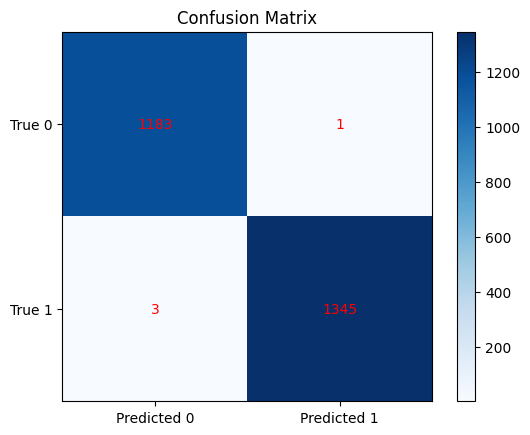

In [150]:
plt.imshow(confusion_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], labels=['Predicted 0', 'Predicted 1'])
plt.yticks([0, 1], labels=['True 0', 'True 1'])

for i in range(2):
    for j in range(2):
        plt.text(j, i, confusion_matrix[i, j].item(), ha='center', va='center', color='red')

plt.show()

# A3.Softmax Regression

### Multi-class Classification Task

In [109]:
def softmax(z):
    exp_z = torch.exp(z - torch.max(z, dim=1, keepdim=True).values)
    return exp_z / torch.sum(exp_z, dim=1, keepdim=True)

In [110]:
def cross_entropy_loss(predictions, targets):
    num_samples = predictions.shape[0]
    log_probs = -torch.log(predictions[range(num_samples), targets])
    loss = torch.mean(log_probs)
    return loss

In [111]:
number_of_features=28*28 
number_of_classes=10

W_multi=torch.zeros((number_of_features,number_of_classes),requires_grad=True)
b_multi=torch.zeros((1,number_of_classes),requires_grad=True)

lr=0.01
num_epochs=10

In [112]:
training_losses=[]
validation_losses=[]
training_accuracies=[]
validation_accuracies=[]

In [124]:
start= time.time()
for epoch in range(num_epochs):
    total_loss=0
    total_correct=0
    total=0
    for images,labels in training_loader:
        trained_data=images.view(-1,28*28)

        scores=linear_output(trained_data,W_multi,b_multi)
        training_predictions=softmax(scores)

        loss=cross_entropy_loss(training_predictions,labels)
        loss.backward()

        predections=torch.argmax(training_predictions,dim=1)

        total_correct+=(predections==labels).sum().item()
        total+=labels.size(0)
        total_loss+=loss.item()*labels.size(0)

        with torch.no_grad():
            W_multi-=lr*W_multi.grad
            b_multi-=lr*b_multi.grad
        W_multi.grad.zero_()
        b_multi.grad.zero_()


    training_loss=total_loss/total
    training_accuracy=total_correct/total
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)


    with torch.no_grad():
        total_val_loss=0
        total_val_correct=0
        total_val=0
        for val_images,val_labels in validation_loader:
            val_trained_data=val_images.view(-1,28*28)

            val_scores=linear_output(val_trained_data,W_multi,b_multi)
            val_predictions=softmax(val_scores)

            val_loss=cross_entropy_loss(val_predictions,val_labels)

            val_predections=torch.argmax(val_predictions,dim=1)

            total_val_correct+=(val_predections==val_labels).sum().item()
            total_val+=val_labels.size(0)
            total_val_loss+=val_loss.item()*val_labels.size(0)

        validation_loss=total_val_loss/total_val
        validation_accuracy=total_val_correct/total_val
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}')
end = time.time()
softmax_time= end-start
print(softmax_time)

Epoch [1/10], Training Loss: 0.3779, Validation Loss: 0.3907
Epoch [2/10], Training Loss: 0.3713, Validation Loss: 0.3852
Epoch [3/10], Training Loss: 0.3656, Validation Loss: 0.3796
Epoch [4/10], Training Loss: 0.3605, Validation Loss: 0.3751
Epoch [5/10], Training Loss: 0.3559, Validation Loss: 0.3715
Epoch [6/10], Training Loss: 0.3517, Validation Loss: 0.3680
Epoch [7/10], Training Loss: 0.3480, Validation Loss: 0.3650
Epoch [8/10], Training Loss: 0.3444, Validation Loss: 0.3619
Epoch [9/10], Training Loss: 0.3414, Validation Loss: 0.3587
Epoch [10/10], Training Loss: 0.3384, Validation Loss: 0.3559
9.573012828826904


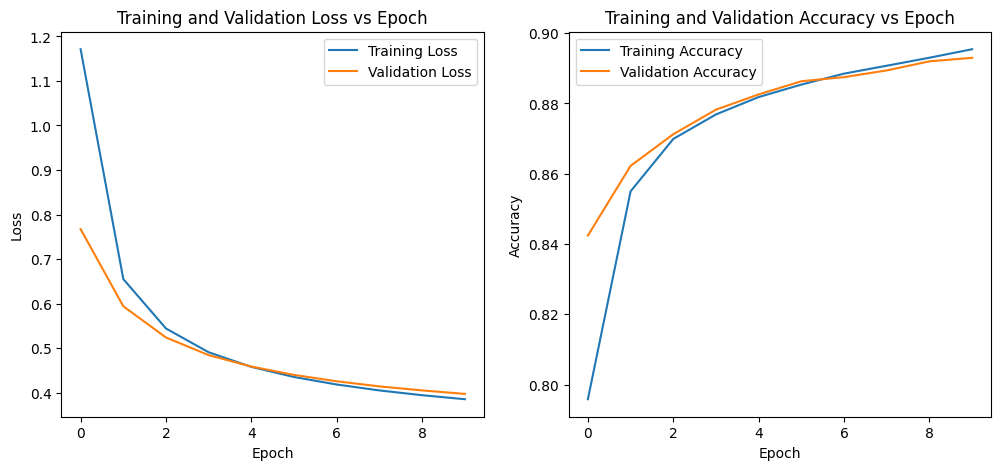

In [114]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(training_losses,label='Training Loss')
plt.plot(validation_losses,label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(training_accuracies,label='Training Accuracy')
plt.plot(validation_accuracies,label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Epoch')
plt.legend()

plt.show()

In [115]:
confusion_matrix_multi=torch.zeros(number_of_classes,number_of_classes,dtype=torch.int32)
total_correct=0
total=0
with torch.no_grad():
    for test_images,test_labels in testing_loader:
        test_trained_data=test_images.view(-1,28*28)

        test_scores=linear_output(test_trained_data,W_multi,b_multi)
        test_predictions=softmax(test_scores)

        test_predections=torch.argmax(test_predictions,dim=1)

        total_correct+=(test_predections==test_labels).sum().item()
        total+=test_labels.size(0)

        for true_label, pred_label in zip(test_labels, test_predections):
            confusion_matrix_multi[int(true_label.item()), int(pred_label.item())] += 1
test_accuracy=total_correct/total
softmax_accuracy = test_accuracy*100;
print(f'Test Accuracy: {softmax_accuracy:.2f}%')

Test Accuracy: 89.25%


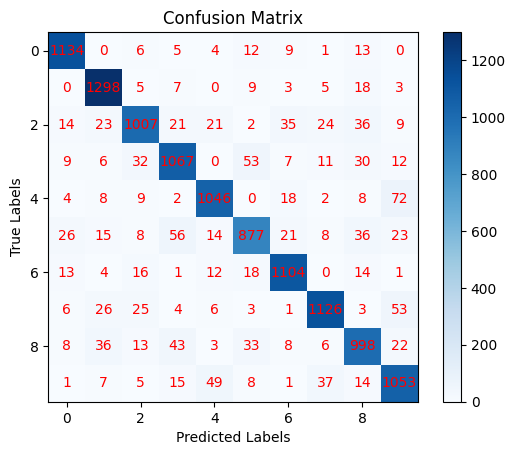

In [122]:
plt.imshow(confusion_matrix_multi, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

for i in range(number_of_classes):
    for j in range(number_of_classes):
        plt.text(j, i, confusion_matrix_multi[i, j].item(), ha='center', va='center', color='red')

plt.show()

In [117]:
accuracy_per_class=confusion_matrix_multi.diagonal()/confusion_matrix_multi.sum(dim=1)
for i, accuracy in enumerate(accuracy_per_class):
    print(f'Accuracy for class {i}: {accuracy.item()*100:.2f}%')


Accuracy for class 0: 95.78%
Accuracy for class 1: 96.29%
Accuracy for class 2: 84.48%
Accuracy for class 3: 86.96%
Accuracy for class 4: 89.48%
Accuracy for class 5: 80.90%
Accuracy for class 6: 93.32%
Accuracy for class 7: 89.86%
Accuracy for class 8: 85.30%
Accuracy for class 9: 88.49%


## Neural Network

In [118]:
class ForwardNN(nn.Module):
    def __init__(self, input=784, hidden=None, output=10):
        super(ForwardNN,self).__init__()
        if hidden is None:
            hidden = [256, 18]
        layers=[]
        prev = input
        for hid in hidden:
            layers.append(nn.Linear(prev, hid))
            layers.append(nn.ReLU())
            prev = hid
        layers.append(nn.Linear(prev, output))
        self.network = nn.Sequential(*layers)
        for layer in layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
    def forward(self,x):
        return self.network(x)

In [119]:
def calculate_accuracy(model, dataloader):
    model.eval() 
    correct = 0
    total = 0
    with torch.no_grad():  
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(torch.device("cpu")), labels.to(torch.device("cpu"))
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


In [192]:
def train(model,epochs,lr,patience=5,training_loader=training_loader,validation_loader=validation_loader):
    criterion = nn.CrossEntropyLoss()
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    tl,vl = [],[]
    ta,va=[],[]
    batch_losses=[]
    pc=0
    best_val_loss=float('inf')
    for epoch in range(epochs):
        model.train()  
        curloss=0.0
        batch_loss=[]
        
        for inputs, labels in training_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            opt.zero_grad()
            loss.backward() #calculate grad  
            opt.step() # update weights 
            curloss += loss.item() * inputs.size(0)
            batch_loss.append(loss.item())
        batch_losses.append(batch_loss)
        epoch_train_loss =curloss/len(training_loader.dataset)
        
        #validation
        model.eval()
        valloss = 0.0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valloss += loss.item() * inputs.size(0)
        epoch_val_loss = valloss / len(validation_loader.dataset)
        train_acc =calculate_accuracy(model, training_loader)
        val_acc =calculate_accuracy(model, validation_loader)
        tl.append(epoch_train_loss)
        vl.append(epoch_val_loss)
        ta.append(train_acc)
        va.append(val_acc) 
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            pc = 0
            best_model_state = model.state_dict()  # save best model weights
        else:
            pc += 1

        if pc >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            model.load_state_dict(best_model_state)  # restore best model
            break
    return tl,vl,ta,va,batch_losses

In [123]:
model = ForwardNN(input=784, hidden=None, output=10)
tl,vl,ta,va,batch=train(model,50,0.01)

Epoch [1/50] Train Loss: 1.2900, Val Loss: 0.6730, Train Acc: 83.78%, Val Acc: 83.37%
Epoch [2/50] Train Loss: 0.5225, Val Loss: 0.4485, Train Acc: 88.50%, Val Acc: 87.99%
Epoch [3/50] Train Loss: 0.3924, Val Loss: 0.3759, Train Acc: 90.08%, Val Acc: 89.63%
Epoch [4/50] Train Loss: 0.3384, Val Loss: 0.3387, Train Acc: 91.03%, Val Acc: 90.62%
Epoch [5/50] Train Loss: 0.3061, Val Loss: 0.3117, Train Acc: 91.78%, Val Acc: 91.42%
Epoch [6/50] Train Loss: 0.2827, Val Loss: 0.2933, Train Acc: 92.25%, Val Acc: 91.76%
Epoch [7/50] Train Loss: 0.2639, Val Loss: 0.2797, Train Acc: 92.78%, Val Acc: 92.06%
Epoch [8/50] Train Loss: 0.2484, Val Loss: 0.2650, Train Acc: 93.28%, Val Acc: 92.57%
Epoch [9/50] Train Loss: 0.2342, Val Loss: 0.2513, Train Acc: 93.56%, Val Acc: 92.83%
Epoch [10/50] Train Loss: 0.2221, Val Loss: 0.2394, Train Acc: 94.01%, Val Acc: 93.29%
Epoch [11/50] Train Loss: 0.2105, Val Loss: 0.2315, Train Acc: 94.22%, Val Acc: 93.26%
Epoch [12/50] Train Loss: 0.2004, Val Loss: 0.2226, 

In [74]:
test_accNN = calculate_accuracy(model, testing_loader)
print(f"Final Test Accuracy: {test_accNN:.2f}%")

Final Test Accuracy: 97.27%


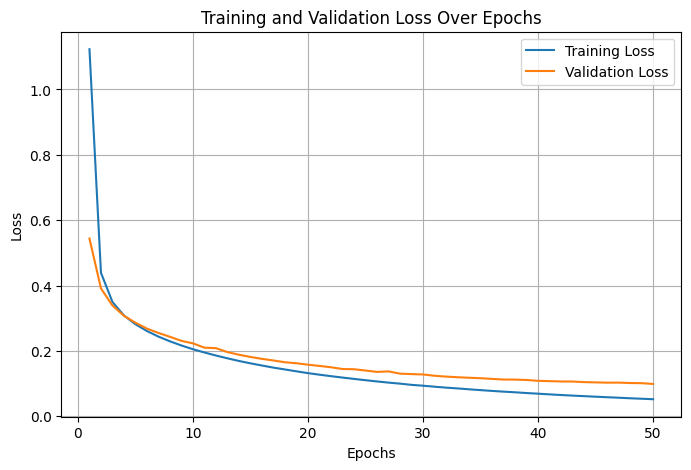

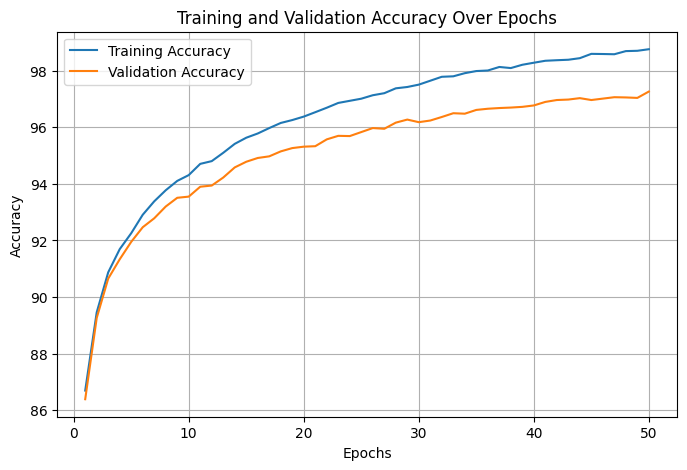

In [39]:
epochs_range = range(1, len(tl) + 1)
plt.figure(figsize=(8,5))
plt.plot(epochs_range,tl, label='Training Loss')
plt.plot(epochs_range,vl, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(8,5))
plt.plot(epochs_range,ta, label='Training Accuracy')
plt.plot(epochs_range,va, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

🔁 Running training... Run 1/5
Epoch [1/30] Train Loss: 1.0488, Val Loss: 0.5242, Train Acc: 87.22%, Val Acc: 86.96%
Epoch [2/30] Train Loss: 0.4245, Val Loss: 0.3829, Train Acc: 89.83%, Val Acc: 89.77%
Epoch [3/30] Train Loss: 0.3437, Val Loss: 0.3369, Train Acc: 91.13%, Val Acc: 90.81%
Epoch [4/30] Train Loss: 0.3057, Val Loss: 0.3149, Train Acc: 91.78%, Val Acc: 91.38%
Epoch [5/30] Train Loss: 0.2796, Val Loss: 0.2877, Train Acc: 92.46%, Val Acc: 91.92%
Epoch [6/30] Train Loss: 0.2594, Val Loss: 0.2704, Train Acc: 92.95%, Val Acc: 92.39%
Epoch [7/30] Train Loss: 0.2431, Val Loss: 0.2551, Train Acc: 93.45%, Val Acc: 92.81%
Epoch [8/30] Train Loss: 0.2287, Val Loss: 0.2421, Train Acc: 93.80%, Val Acc: 93.17%
Epoch [9/30] Train Loss: 0.2163, Val Loss: 0.2317, Train Acc: 94.17%, Val Acc: 93.49%
Epoch [10/30] Train Loss: 0.2049, Val Loss: 0.2219, Train Acc: 94.42%, Val Acc: 93.67%
Epoch [11/30] Train Loss: 0.1949, Val Loss: 0.2120, Train Acc: 94.76%, Val Acc: 94.06%
Epoch [12/30] Train Lo

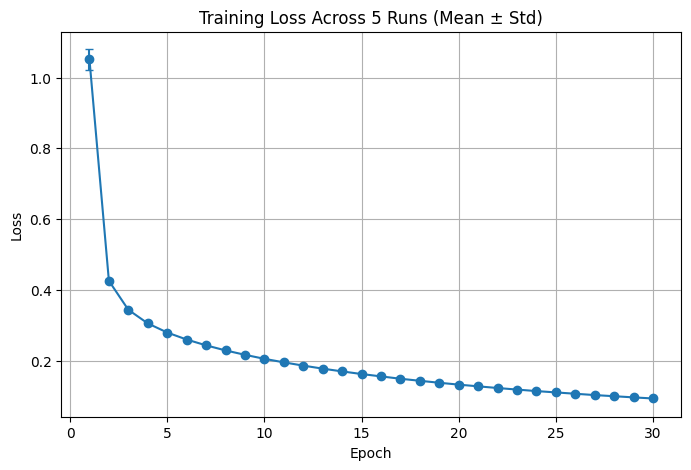

In [80]:
runs = 5
all_train_losses = []  
for r in range(runs):
    print(f" Running training... Run {r+1}/{runs}")
    model = ForwardNN(hidden=[256,128])
    train_losses, val_losses, train_accs, val_accs, _ = train(model, epochs=30,lr=0.01)
    all_train_losses.append(train_losses)
all_train_losses = np.array(all_train_losses)
train_mean = np.mean(all_train_losses, axis=0)
train_std  = np.std(all_train_losses, axis=0)
epochs_range = range(1, len(train_mean)+1)
plt.figure(figsize=(8,5))
plt.errorbar(epochs_range, train_mean, yerr=train_std, fmt='-o', capsize=3)
plt.title("Training Loss Across 5 Runs (Mean ± Std)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


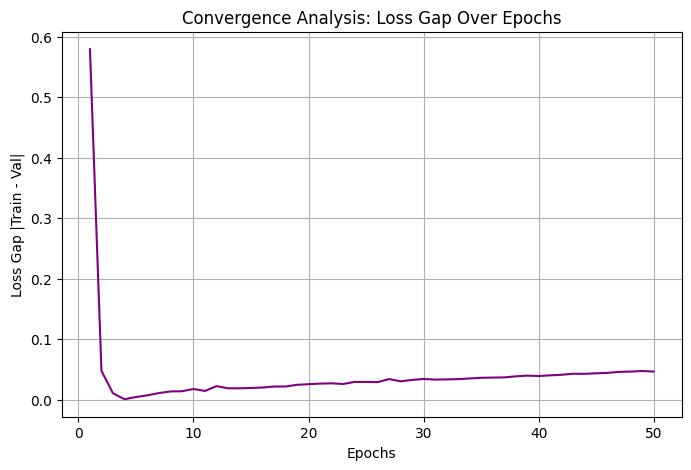

In [41]:
loss_gap = np.abs(np.array(tl) - np.array(vl))
plt.figure(figsize=(8,5))
plt.plot(epochs_range, loss_gap, color='purple')
plt.xlabel('Epochs')
plt.ylabel('Loss Gap |Train - Val|')
plt.title('Convergence Analysis: Loss Gap Over Epochs')
plt.grid(True)
plt.show()

## Part C: Comprehensive Analysis

# C1. Hyperparameter Analysis

## Learning Rate Analysis

In [43]:
# learning rate analysis
learning_rates = [0.001, 0.01, 0.1, 1.0]
results_lr = {}

In [55]:
for lr in learning_rates:
    print(f"\n==== Training with Learning Rate = {lr} ====")
    model = ForwardNN()
    train_losses, val_losses, train_accs, val_accs,bl = train(model,50,lr)
    results_lr[lr] = (train_losses, val_losses, train_accs, val_accs)


==== Training with Learning Rate = 0.001 ====


KeyboardInterrupt: 

In [204]:
best_lr = None
best_acc = -1

for lr, result in results_lr.items():
    _, _, _, val_accs = result
    final_acc = val_accs[-1]  # last validation accuracy
    if final_acc > best_acc:
        best_acc = final_acc
        best_lr = lr
print(f"Best Learning Rate: {best_lr}")
print(f"Best Validation Accuracy: {best_acc:.2f}%")


Best Learning Rate: 0.1
Best Validation Accuracy: 97.83%



==== Training with Learning Rate = 0.001 ====
Epoch [1/50] Train Loss: 2.1776, Val Loss: 2.0164, Train Acc: 49.23%, Val Acc: 49.15%
Epoch [2/50] Train Loss: 1.8368, Val Loss: 1.6583, Train Acc: 69.42%, Val Acc: 69.28%
Epoch [3/50] Train Loss: 1.4716, Val Loss: 1.3052, Train Acc: 76.58%, Val Acc: 76.54%
Epoch [4/50] Train Loss: 1.1549, Val Loss: 1.0355, Train Acc: 79.98%, Val Acc: 79.88%
Epoch [5/50] Train Loss: 0.9317, Val Loss: 0.8577, Train Acc: 81.96%, Val Acc: 81.80%
Epoch [6/50] Train Loss: 0.7869, Val Loss: 0.7423, Train Acc: 83.50%, Val Acc: 83.18%
Epoch [7/50] Train Loss: 0.6906, Val Loss: 0.6634, Train Acc: 84.68%, Val Acc: 84.17%
Epoch [8/50] Train Loss: 0.6232, Val Loss: 0.6067, Train Acc: 85.41%, Val Acc: 85.05%
Epoch [9/50] Train Loss: 0.5734, Val Loss: 0.5641, Train Acc: 86.16%, Val Acc: 85.74%
Epoch [10/50] Train Loss: 0.5350, Val Loss: 0.5306, Train Acc: 86.78%, Val Acc: 86.24%
Epoch [11/50] Train Loss: 0.5046, Val Loss: 0.5039, Train Acc: 87.36%, Val Acc: 86.88%
Epoch

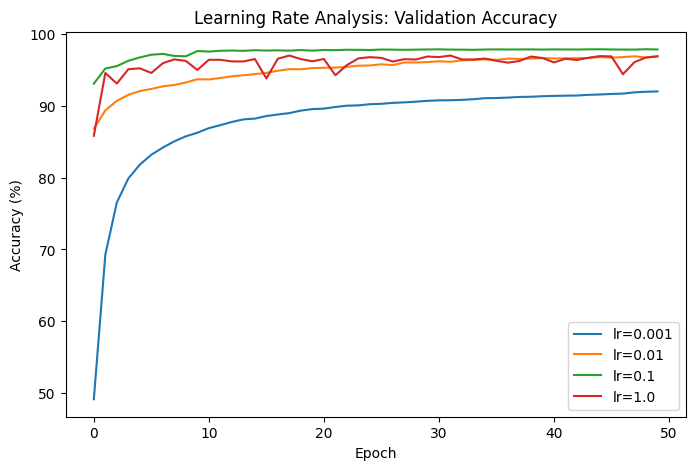

In [53]:
plt.figure(figsize=(8, 5))
for lr, (_, _, _, val_accs) in results_lr.items():
    plt.plot(val_accs, label=f"lr={lr}")
plt.title("Learning Rate Analysis: Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

##  Analyze convergence speed and stability 
R = 0.001:
Learns very slowly but is stable.

LR = 0.01:
Fast learning and very stable — best performance.

LR = 0.1:
Learns very fast but has small ups and downs.

LR = 1.0:
Very unstable — accuracy jumps a lot and does not settle.


# Batch Size Analysis


==== Training with Batch Size = 16 ====
Epoch [1/30] Train Loss: 0.6446, Val Loss: 0.3539, Train Acc: 90.27%, Val Acc: 89.92%
Epoch [2/30] Train Loss: 0.2858, Val Loss: 0.2579, Train Acc: 93.17%, Val Acc: 92.81%
Epoch [3/30] Train Loss: 0.2215, Val Loss: 0.2194, Train Acc: 94.38%, Val Acc: 93.73%
Epoch [4/30] Train Loss: 0.1833, Val Loss: 0.1860, Train Acc: 95.46%, Val Acc: 94.51%
Epoch [5/30] Train Loss: 0.1558, Val Loss: 0.1616, Train Acc: 96.32%, Val Acc: 95.32%
Epoch [6/30] Train Loss: 0.1356, Val Loss: 0.1471, Train Acc: 96.77%, Val Acc: 95.63%
Epoch [7/30] Train Loss: 0.1186, Val Loss: 0.1368, Train Acc: 97.03%, Val Acc: 95.88%
Epoch [8/30] Train Loss: 0.1047, Val Loss: 0.1326, Train Acc: 97.40%, Val Acc: 96.10%
Epoch [9/30] Train Loss: 0.0938, Val Loss: 0.1250, Train Acc: 97.58%, Val Acc: 96.32%
Epoch [10/30] Train Loss: 0.0836, Val Loss: 0.1195, Train Acc: 97.91%, Val Acc: 96.44%
Epoch [11/30] Train Loss: 0.0757, Val Loss: 0.1085, Train Acc: 98.34%, Val Acc: 96.74%
Epoch [12/3

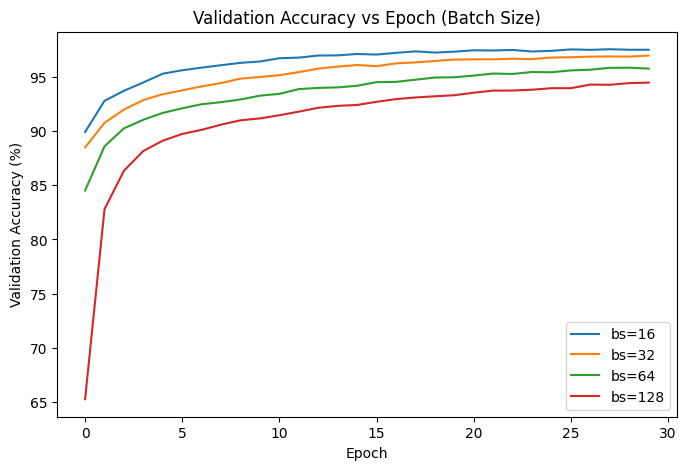

In [191]:
batch_sizes = [16, 32, 64, 128]
results_bs = []
plt.figure(figsize=(8, 5))
for bs in batch_sizes:
    print(f"\n==== Training with Batch Size = {bs} ====")
    train_loader = DataLoader(trainig_dataset, batch_size=bs, shuffle=True)
    val_loader = DataLoader(validation_dataset, batch_size=bs, shuffle=False)
    model = ForwardNN()
    start_time = time.time()
    train_losses, val_losses, train_accs, val_accs ,bl= train(
        model,30,0.01,5,train_loader,val_loader
    )
    elapsed = time.time() - start_time
    results_bs.append((bs, val_accs[-1], round(elapsed, 1)))
    plt.plot(val_accs, label=f'bs={bs}')

plt.title('Validation Accuracy vs Epoch (Batch Size)')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.show()

In [193]:
best_bs = None
best_acc = -1
best_time = None

for bs, acc, t in results_bs:
    if acc > best_acc:
        best_acc = acc
        best_bs = bs
        best_time = t

In [194]:
# create a summary table
batch_results_df = pd.DataFrame(
    results_bs, columns=['Batch Size', 'Final Val Accuracy (%)', 'Training Time (s)']   
)

print("\nBatch Size Comparison:")
print(batch_results_df)


Batch Size Comparison:
   Batch Size  Final Val Accuracy (%)  Training Time (s)
0          16               97.525000              180.0
1          32               96.991667              124.6
2          64               95.783333              101.9
3         128               94.491667               72.5


 # Analyze effect on gradient noise 
Batch Size = 16:
Highest gradient noise — updates jump a lot.
Slower but can generalize better.

Batch Size = 32:
Moderate noise — good balance between stability and learning.

Batch Size = 64:
Low noise — smoother training, faster convergence.

Batch Size = 128:
Very low noise — stable but may get stuck and give slightly worse accuracy.

## Architecture Analysis

In [171]:
number_of_layers = [2,3,4,5]
neurons = [64,128,256,512]
architectures=[]
for layers in number_of_layers:
    for neuron in neurons:
        architectures.append([neuron]*layers)
architectures


[[64, 64],
 [128, 128],
 [256, 256],
 [512, 512],
 [64, 64, 64],
 [128, 128, 128],
 [256, 256, 256],
 [512, 512, 512],
 [64, 64, 64, 64],
 [128, 128, 128, 128],
 [256, 256, 256, 256],
 [512, 512, 512, 512],
 [64, 64, 64, 64, 64],
 [128, 128, 128, 128, 128],
 [256, 256, 256, 256, 256],
 [512, 512, 512, 512, 512]]

In [198]:
results = []
for arch in architectures:
    print(f"\nTraining architecture: {arch}")
    model = ForwardNN(hidden = arch)
    start_time = time.time()
    train_losses, val_losses, train_accs, val_accs,bl = train(model,30,0.01)
    elapsed =round(time.time() - start_time,2)
    results.append({
        "Architecture":arch,
        "Layers": len(arch),
        "Neurons": arch[0],
        "Best Val Accuracy": round(max(val_accs), 2),
        "Time (s)": elapsed
    })



Training architecture: [64, 64]
Epoch [1/30] Train Loss: 1.3725, Val Loss: 0.6981, Train Acc: 82.30%, Val Acc: 81.84%
Epoch [2/30] Train Loss: 0.5348, Val Loss: 0.4537, Train Acc: 87.90%, Val Acc: 87.61%
Epoch [3/30] Train Loss: 0.3985, Val Loss: 0.3843, Train Acc: 89.67%, Val Acc: 89.38%
Epoch [4/30] Train Loss: 0.3455, Val Loss: 0.3436, Train Acc: 90.69%, Val Acc: 90.43%
Epoch [5/30] Train Loss: 0.3141, Val Loss: 0.3231, Train Acc: 91.36%, Val Acc: 90.88%
Epoch [6/30] Train Loss: 0.2922, Val Loss: 0.3003, Train Acc: 91.92%, Val Acc: 91.58%
Epoch [7/30] Train Loss: 0.2743, Val Loss: 0.2878, Train Acc: 92.33%, Val Acc: 91.88%
Epoch [8/30] Train Loss: 0.2599, Val Loss: 0.2726, Train Acc: 92.92%, Val Acc: 92.26%
Epoch [9/30] Train Loss: 0.2474, Val Loss: 0.2629, Train Acc: 93.26%, Val Acc: 92.66%
Epoch [10/30] Train Loss: 0.2363, Val Loss: 0.2519, Train Acc: 93.48%, Val Acc: 92.86%
Epoch [11/30] Train Loss: 0.2266, Val Loss: 0.2494, Train Acc: 93.52%, Val Acc: 92.85%
Epoch [12/30] Train

In [199]:
df = pd.DataFrame(results)
print(df)

                 Architecture  Layers  Neurons  Best Val Accuracy  Time (s)
0                    [64, 64]       2       64              95.20     47.81
1                  [128, 128]       2      128              95.92     66.26
2                  [256, 256]       2      256              95.99     84.32
3                  [512, 512]       2      512              96.33    132.24
4                [64, 64, 64]       3       64              95.92     79.88
5             [128, 128, 128]       3      128              96.60     87.17
6             [256, 256, 256]       3      256              96.75    124.69
7             [512, 512, 512]       3      512              97.01    200.83
8            [64, 64, 64, 64]       4       64              96.39     77.10
9        [128, 128, 128, 128]       4      128              96.42     63.72
10       [256, 256, 256, 256]       4      256              97.01     96.04
11       [512, 512, 512, 512]       4      512              97.28    259.90
12       [64

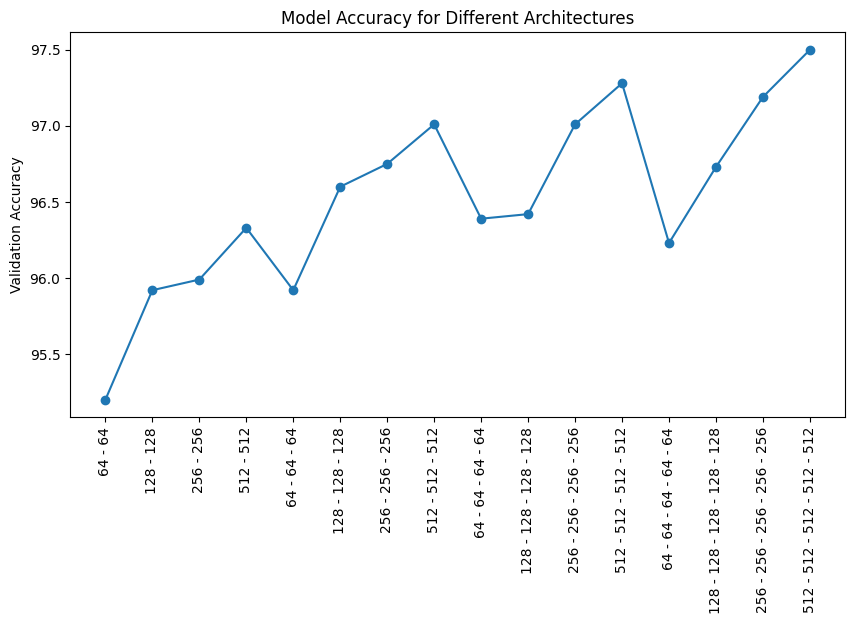

[512, 512, 512, 512, 512]

In [200]:
df["Architecture_str"] = df["Architecture"].apply(lambda x: " - ".join(map(str, x)))
plt.figure(figsize=(10,5))
plt.plot(df["Architecture_str"], df["Best Val Accuracy"], marker="o")
plt.xticks(rotation=90)
plt.ylabel("Validation Accuracy")
plt.title("Model Accuracy for Different Architectures")
plt.show()
best = df.loc[df["Best Val Accuracy"].idxmax()]
best_arch = best["Architecture"]
best_arch


## Comparative Analysis

In [201]:
comparison_data = {
    "Model": ["Logistic Regression", "Softmax Regression", "Best Neural Network"],
    "Test Accuracy (%)": [logistic_regression_acc, softmax_accuracy, max(df["Best Val Accuracy"])],
    "Training Time (s)": [logistic_regression_time, softmax_time, df["Time (s)"].min()]
}

In [202]:
comparison_df = pd.DataFrame(comparison_data)
print("\n=== Model Comparison Summary ===")
print(comparison_df)


=== Model Comparison Summary ===
                 Model  Test Accuracy (%)  Training Time (s)
0  Logistic Regression          99.842024           3.461030
1   Softmax Regression          89.250000           9.573013
2  Best Neural Network          97.500000          47.810000


Models

Logistic Regression: Basic model, works for simple data  Small/simple dataset

Softmax Regression: Like logistic but for multi-class   Small/simple dataset

Neural Network: More advanced, learns complex patterns    Large/complex data


Logistic and softmax regression are simple and fast but limited.
Neural networks take longer to train but give the highest accuracy, especially on complex data.

## Best Model Evaluation

In [205]:
best_model = ForwardNN(input=784, hidden=best_arch, output=10)
train_loader = DataLoader(trainig_dataset, batch_size=best_bs, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=best_bs, shuffle=False)
train(best_model,30,best_lr,5,train_loader,val_loader)
test_accNN = calculate_accuracy(best_model, testing_loader)
print(f"Final Test Accuracy: {test_accNN:.2f}%")

Epoch [1/30] Train Loss: 0.3200, Val Loss: 0.2103, Train Acc: 94.84%, Val Acc: 93.74%
Epoch [2/30] Train Loss: 0.1241, Val Loss: 0.1258, Train Acc: 97.26%, Val Acc: 96.17%
Epoch [3/30] Train Loss: 0.0835, Val Loss: 0.1095, Train Acc: 98.23%, Val Acc: 96.90%
Epoch [4/30] Train Loss: 0.0622, Val Loss: 0.0966, Train Acc: 98.96%, Val Acc: 97.29%
Epoch [5/30] Train Loss: 0.0486, Val Loss: 0.0853, Train Acc: 99.25%, Val Acc: 97.62%
Epoch [6/30] Train Loss: 0.0345, Val Loss: 0.0905, Train Acc: 99.14%, Val Acc: 97.38%
Epoch [7/30] Train Loss: 0.0290, Val Loss: 0.0913, Train Acc: 99.59%, Val Acc: 97.70%
Epoch [8/30] Train Loss: 0.0251, Val Loss: 0.0819, Train Acc: 99.67%, Val Acc: 97.81%
Epoch [9/30] Train Loss: 0.0249, Val Loss: 0.0919, Train Acc: 99.58%, Val Acc: 97.63%
Epoch [10/30] Train Loss: 0.0183, Val Loss: 0.1144, Train Acc: 99.32%, Val Acc: 97.21%
Epoch [11/30] Train Loss: 0.0182, Val Loss: 0.0952, Train Acc: 99.70%, Val Acc: 97.63%
Epoch [12/30] Train Loss: 0.0138, Val Loss: 0.0942, 

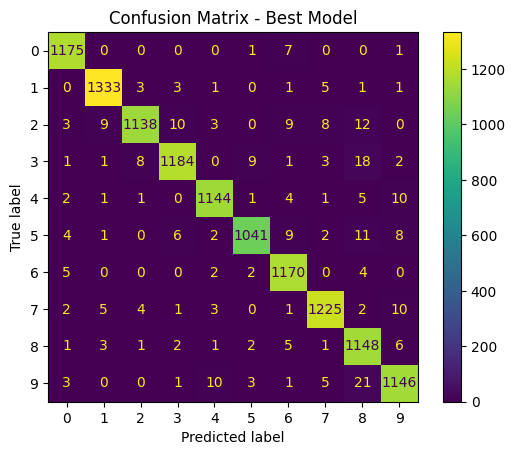

In [207]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []
best_model.eval()
with torch.no_grad():
    for x, y in testing_loader:
        preds = best_model(x)
        preds = preds.argmax(dim=1)
        all_preds.extend(preds.cpu())
        all_labels.extend(y.cpu())

cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion Matrix - Best Model")
plt.show()

## Miss Classifcation

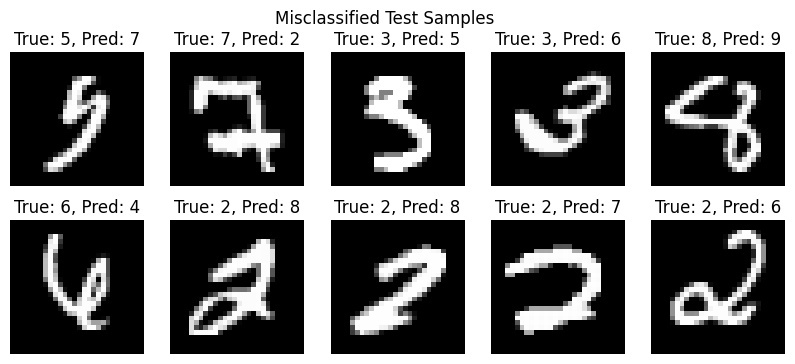

In [208]:
incorrect_imgs = []
incorrect_pred = []
incorrect_true = []

best_model.eval()
with torch.no_grad():
    for x, y in testing_loader:
        preds = best_model(x).argmax(dim=1)
        for img, p, t in zip(x, preds, y):
            if p != t:
                incorrect_imgs.append(img)
                incorrect_pred.append(p.item())
                incorrect_true.append(t.item())
            if len(incorrect_imgs) == 10:  
                break
        if len(incorrect_imgs) == 10:
            break

fig, axes = plt.subplots(2,5, figsize=(10,4))
for i, ax in enumerate(axes.flat):
    ax.imshow(incorrect_imgs[i].reshape(28,28), cmap="gray")
    ax.set_title(f"True: {incorrect_true[i]}, Pred: {incorrect_pred[i]}")
    ax.axis('off')
plt.suptitle("Misclassified Test Samples")
plt.show()


True 5 → Pred 7: The 5 has a slanted or open top, which looks similar to a 7.

True 3 → Pred 5 / 6: Some 3s are written with a closed top loop, making them resemble 5 or 6.

True 2 → Pred 6 / 7 / 8: The 2s have loops or curves that make them visually similar to 6, 7, or 8.

Insight: Even humans sometimes misread poorly written digits; the nueral network struggles with unusual handwriting

#Insights & Limitations

Misclassification Observations:

Most errors happened on similar looking classes

Some digits/images are badly written/noisy

Limitations:

Requires more training time than logistic/softmax regression

## CNN

In [226]:
class CNN(nn.Module):
    def __init__(self,dropout=0.0,batch=False):
        super(CNN, self).__init__()
        layers1 = [
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2), 
        ]
        if batch:
            layers1.append(nn.BatchNorm2d(16))
        layers1 += [
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        ]
        self.cn1 = nn.Sequential(*layers1)
        layers2 = [
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
        ]
        if batch:
            layers2.append(nn.BatchNorm2d(32))
        layers2 += [
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        ]
        self.cn2 = nn.Sequential(*layers2)

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        x=x.view(-1,1,28,28)
        x = self.cn1(x)
        x = self.cn2(x)
        x = self.flatten(x)
        logits = self.fc(x)
        return logits

In [212]:
modelCNN= CNN()
tl,vl,ta,va,_=train(modelCNN,30,0.01)

Epoch [1/30] Train Loss: 1.6653, Val Loss: 0.6265, Train Acc: 81.40%, Val Acc: 81.47%
Epoch [2/30] Train Loss: 0.4087, Val Loss: 0.3641, Train Acc: 88.21%, Val Acc: 88.50%
Epoch [3/30] Train Loss: 0.2625, Val Loss: 0.3051, Train Acc: 90.30%, Val Acc: 89.86%
Epoch [4/30] Train Loss: 0.1987, Val Loss: 0.1865, Train Acc: 94.50%, Val Acc: 94.09%
Epoch [5/30] Train Loss: 0.1610, Val Loss: 0.1644, Train Acc: 95.38%, Val Acc: 95.00%
Epoch [6/30] Train Loss: 0.1371, Val Loss: 0.1354, Train Acc: 96.28%, Val Acc: 95.78%
Epoch [7/30] Train Loss: 0.1209, Val Loss: 0.1157, Train Acc: 96.76%, Val Acc: 96.44%
Epoch [8/30] Train Loss: 0.1084, Val Loss: 0.1058, Train Acc: 97.12%, Val Acc: 96.75%
Epoch [9/30] Train Loss: 0.0988, Val Loss: 0.1079, Train Acc: 96.92%, Val Acc: 96.56%
Epoch [10/30] Train Loss: 0.0913, Val Loss: 0.0961, Train Acc: 97.37%, Val Acc: 97.08%
Epoch [11/30] Train Loss: 0.0847, Val Loss: 0.1071, Train Acc: 96.99%, Val Acc: 96.66%
Epoch [12/30] Train Loss: 0.0791, Val Loss: 0.0842, 

In [214]:
test_acc = calculate_accuracy(modelCNN, testing_loader)
print(f"Final Test Accuracy: {test_acc:.2f}%")

Final Test Accuracy: 98.04%


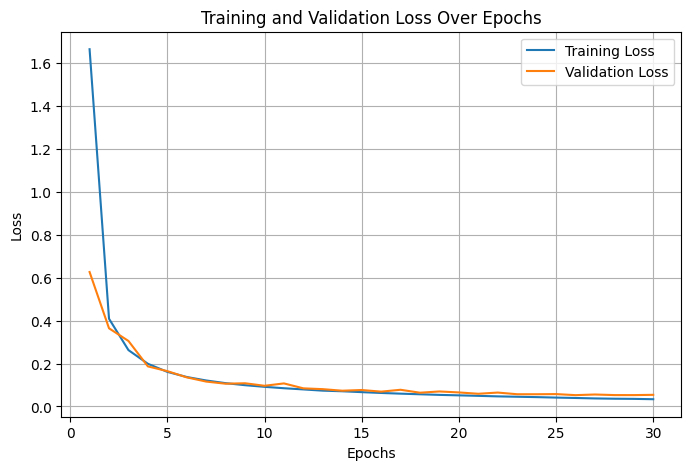

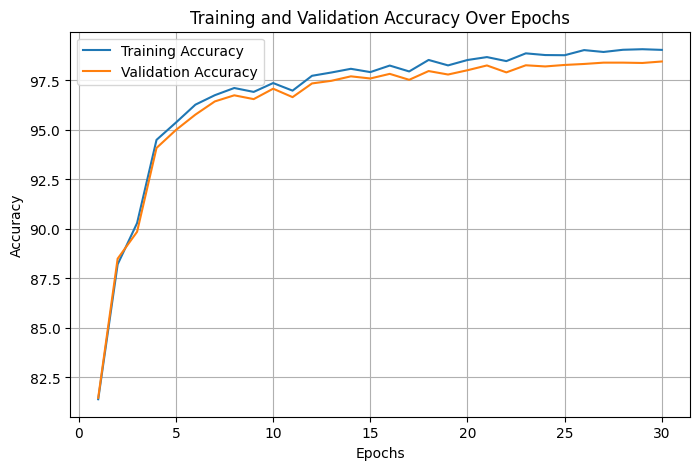

In [215]:
epochs_range = range(1, len(tl) + 1)
plt.figure(figsize=(8,5))
plt.plot(epochs_range,tl, label='Training Loss')
plt.plot(epochs_range,vl, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs_range,ta, label='Training Accuracy')
plt.plot(epochs_range,va, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

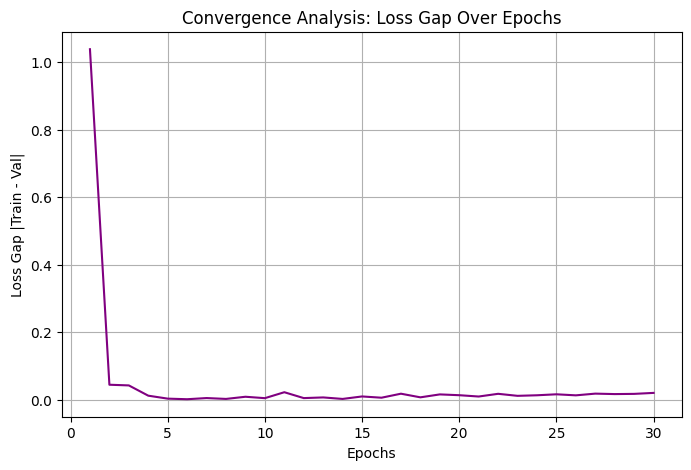

In [216]:
loss_gap = np.abs(np.array(tl) - np.array(vl))
plt.figure(figsize=(8,5))
plt.plot(epochs_range, loss_gap, color='purple')
plt.xlabel('Epochs')
plt.ylabel('Loss Gap |Train - Val|')
plt.title('Convergence Analysis: Loss Gap Over Epochs')
plt.grid(True)
plt.show()

# Comparison
NN 96-97 %
CNN 98-99%
Convolutional Neural Networks preserve the 2D image structure and learn spatial features
Fully-connected networks flatten the image and lose spatial relationships, making them less efficient for vision tasks.

## Dropuout 

In [221]:
dropout_rates = [0.1, 0.3, 0.5, 0.7]
results = {}

for rate in dropout_rates:
    print(f"\n🔹 Training with Dropout rate = {rate}")
    model = CNN(dropout=rate)
    tl, vl, ta, va, _ = train(model, epochs=30, lr=0.01)
    results[rate] = {"train_loss": tl, "val_loss": vl, "train_acc": ta, "val_acc": va}



🔹 Training with Dropout rate = 0.1
Epoch [1/30] Train Loss: 1.8498, Val Loss: 0.6330, Train Acc: 82.40%, Val Acc: 82.67%
Epoch [2/30] Train Loss: 0.4313, Val Loss: 0.3367, Train Acc: 90.41%, Val Acc: 90.23%
Epoch [3/30] Train Loss: 0.2794, Val Loss: 0.2226, Train Acc: 93.62%, Val Acc: 93.17%
Epoch [4/30] Train Loss: 0.2122, Val Loss: 0.2007, Train Acc: 93.94%, Val Acc: 93.52%
Epoch [5/30] Train Loss: 0.1752, Val Loss: 0.1507, Train Acc: 95.81%, Val Acc: 95.22%
Epoch [6/30] Train Loss: 0.1503, Val Loss: 0.1296, Train Acc: 96.46%, Val Acc: 95.92%
Epoch [7/30] Train Loss: 0.1319, Val Loss: 0.1181, Train Acc: 96.86%, Val Acc: 96.23%
Epoch [8/30] Train Loss: 0.1199, Val Loss: 0.1049, Train Acc: 97.12%, Val Acc: 96.61%
Epoch [9/30] Train Loss: 0.1093, Val Loss: 0.1242, Train Acc: 96.36%, Val Acc: 96.11%
Epoch [10/30] Train Loss: 0.1018, Val Loss: 0.1140, Train Acc: 96.76%, Val Acc: 96.23%
Epoch [11/30] Train Loss: 0.0960, Val Loss: 0.0870, Train Acc: 97.70%, Val Acc: 97.24%
Epoch [12/30] Tr

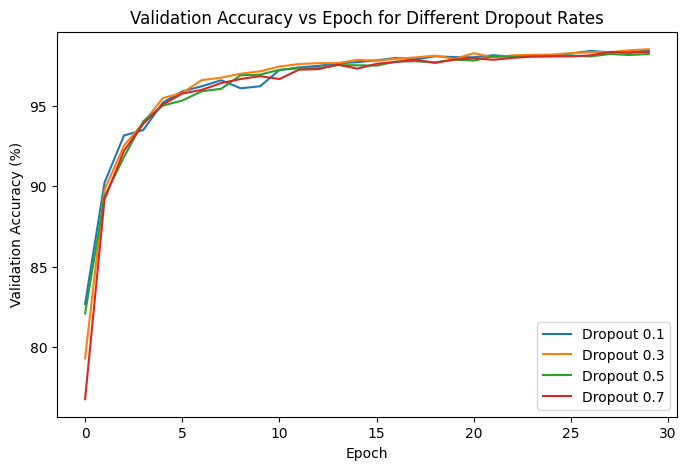

In [223]:
plt.figure(figsize=(8,5))
for rate in dropout_rates:
    plt.plot(results[rate]["val_acc"], label=f"Dropout {rate}")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy vs Epoch for Different Dropout Rates")
plt.legend()
plt.show()

In [224]:
best_rate = max(dropout_rates, key=lambda r: max(results[r]["val_acc"]))
best_val_acc = max(results[best_rate]["val_acc"])
print(f"\n Best Dropout Rate: {best_rate} (Validation Accuracy: {best_val_acc:.2f}%)")


 Best Dropout Rate: 0.3 (Validation Accuracy: 98.54%)


## analysis
All dropout rates eventually converge to high accuracy arround 98%.

Early epochs show a gap: high dropout (0.7) learns slower moderate dropout (0.3–0.5) rises faster.

The best rate (0.3) balances learning speed and generalization.

In [ ]:
#Batch Normalization

In [229]:
configs = [
    {"use_batchnorm": False, "dropout_rate": 0.0, "label": "No BN, No Dropout"},
    {"use_batchnorm": True,  "dropout_rate": 0.0, "label": "BN only"},
    {"use_batchnorm": False, "dropout_rate": best_rate, "label": f"Dropout {best_rate} only"},
    {"use_batchnorm": True,  "dropout_rate": best_rate, "label": f"BN + Dropout {best_rate}"},
]

results = {}

for cfg in configs:
    print(f"\n🔹 Training: {cfg['label']}")
    model = CNN(
        dropout=cfg["dropout_rate"], 
        batch=cfg["use_batchnorm"]
    )
    tl, vl, ta,va,_ = train(model, epochs=30, lr=0.01, training_loader=training_loader, validation_loader=validation_loader)
    results[cfg['label']] = {"train_loss": tl, "val_loss": vl, "val_acc": va}



🔹 Training: No BN, No Dropout
Epoch [1/30] Train Loss: 1.5127, Val Loss: 0.5105, Train Acc: 84.14%, Val Acc: 83.96%
Epoch [2/30] Train Loss: 0.3590, Val Loss: 0.3057, Train Acc: 90.46%, Val Acc: 90.68%
Epoch [3/30] Train Loss: 0.2413, Val Loss: 0.2626, Train Acc: 92.41%, Val Acc: 92.03%
Epoch [4/30] Train Loss: 0.1841, Val Loss: 0.1835, Train Acc: 94.48%, Val Acc: 94.20%
Epoch [5/30] Train Loss: 0.1498, Val Loss: 0.1368, Train Acc: 96.05%, Val Acc: 95.92%
Epoch [6/30] Train Loss: 0.1264, Val Loss: 0.1226, Train Acc: 96.52%, Val Acc: 96.25%
Epoch [7/30] Train Loss: 0.1101, Val Loss: 0.1076, Train Acc: 97.05%, Val Acc: 96.68%
Epoch [8/30] Train Loss: 0.0986, Val Loss: 0.0950, Train Acc: 97.39%, Val Acc: 97.09%
Epoch [9/30] Train Loss: 0.0882, Val Loss: 0.0871, Train Acc: 97.66%, Val Acc: 97.37%
Epoch [10/30] Train Loss: 0.0820, Val Loss: 0.0808, Train Acc: 97.89%, Val Acc: 97.58%
Epoch [11/30] Train Loss: 0.0748, Val Loss: 0.0769, Train Acc: 98.07%, Val Acc: 97.67%
Epoch [12/30] Train L

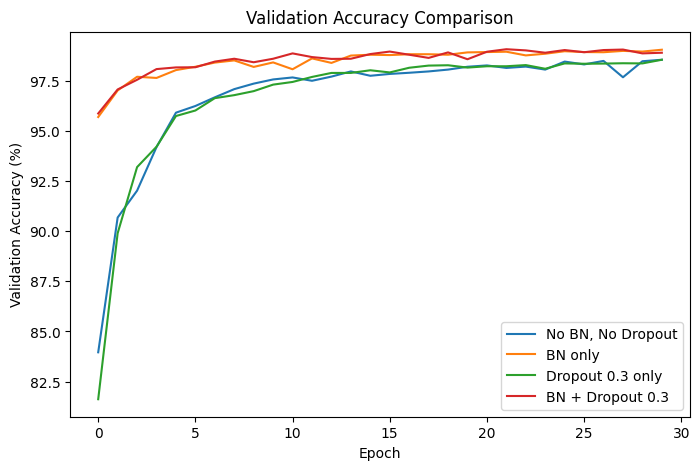

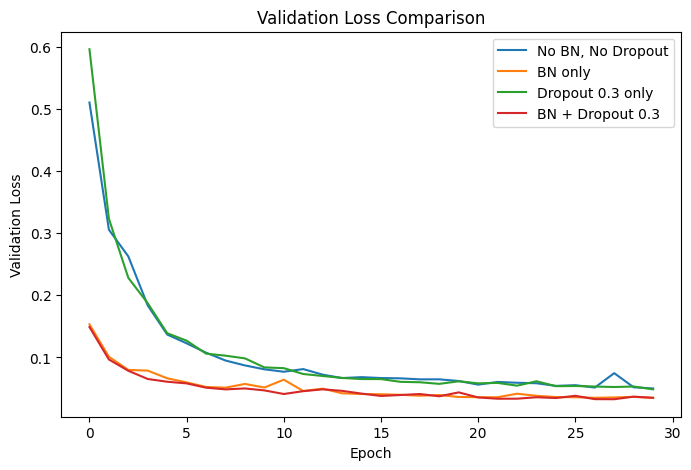

In [230]:
plt.figure(figsize=(8,5))
for label in results.keys():
    plt.plot(results[label]["val_acc"], label=label)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
for label in results.keys():
    plt.plot(results[label]["val_loss"], label=label)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Comparison")
plt.legend()
plt.show()


No BN, No Dropout (blue):

The baseline model shows steady improvement but slower convergence.

It reaches around 97–98% accuracy, indicating decent learning but some instability.

Slight fluctuations suggest mild overfitting or less stable gradients.

BN only (orange):

Achieves the fastest convergence — validation accuracy jumps above 95% within a few epochs.

Maintains consistently high accuracy (~98.7%) with smoother curves.

Confirms that Batch Normalization improves training stability and convergence speed by standardizing activations.

Dropout 0.3 only (green):

Learning starts slower due to the regularization effect.

Final accuracy slightly below BN-only but still strong (~98.4%).

Indicates Dropout helps generalization, though it slows early learning.

BN + Dropout 0.3 (red):

Combines the benefits: fast convergence (from BN) and good generalization (from Dropout).

Achieves the most stable and highest validation accuracy (~98.8–99%).

This configuration minimizes overfitting and provides robust performance.

# Final test with the best regulization

In [231]:
FinalModel = CNN(best_rate,True)
tl, vl, ta,va,_ = train(FinalModel, epochs=30, lr=0.01)

Epoch [1/30] Train Loss: 0.4850, Val Loss: 0.1510, Train Acc: 96.20%, Val Acc: 95.78%
Epoch [2/30] Train Loss: 0.1433, Val Loss: 0.1048, Train Acc: 97.38%, Val Acc: 96.98%
Epoch [3/30] Train Loss: 0.1017, Val Loss: 0.0787, Train Acc: 98.02%, Val Acc: 97.72%
Epoch [4/30] Train Loss: 0.0838, Val Loss: 0.0692, Train Acc: 98.34%, Val Acc: 98.03%
Epoch [5/30] Train Loss: 0.0725, Val Loss: 0.0679, Train Acc: 98.32%, Val Acc: 98.03%
Epoch [6/30] Train Loss: 0.0633, Val Loss: 0.0536, Train Acc: 98.81%, Val Acc: 98.36%
Epoch [7/30] Train Loss: 0.0561, Val Loss: 0.0549, Train Acc: 98.76%, Val Acc: 98.31%
Epoch [8/30] Train Loss: 0.0516, Val Loss: 0.0477, Train Acc: 99.03%, Val Acc: 98.61%
Epoch [9/30] Train Loss: 0.0462, Val Loss: 0.0514, Train Acc: 98.94%, Val Acc: 98.39%
Epoch [10/30] Train Loss: 0.0427, Val Loss: 0.0407, Train Acc: 99.25%, Val Acc: 98.77%
Epoch [11/30] Train Loss: 0.0408, Val Loss: 0.0432, Train Acc: 99.26%, Val Acc: 98.78%
Epoch [12/30] Train Loss: 0.0365, Val Loss: 0.0411, 

In [233]:
test_acc = calculate_accuracy(FinalModel, testing_loader)
print(f"Final Test Accuracy: {test_acc:.2f}%")

Final Test Accuracy: 98.86%
